In [1]:
import matplotlib
import importlib
import ventos.signal as signal
import ventos.test_trace as tt
import ventos.sim.simple as simple
import pandas as pd, matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [10,7]
pd.set_option('precision', 4)

In [2]:
def processed_plots(df):
    df.plot(x='time_s', y=['p', 'vhigh', 'vlow', 'PIP', 'PEEP', 'RR', 'phase'], # 'Vhigh', 'Vlow', # 'Thigh', 'Tlow', 'Tpeak',
            title = "Smoothing "
             rf"($\alpha_A$={config.alphaA:.4f} $\alpha_R$={config.alphaR:.4f} $\alpha_S$={config.alphaS:.4f} $\alpha_N$={config.alphaN:.4f}"
             f" Hz={config.sample_frequency} noise RMS={scenario['pressure_noise_sd']})"
                      )
    plt.show()

{'IE': 0.5,
 'PEEP': 5,
 'Pi': 15,
 'cardiac_amplitude': 0.05,
 'end_time': 240,
 'events': [{'attr': 'PEEP', 'time': 40, 'val': 7},
            {'attr': 'PEEP', 'time': 43, 'val': 10},
            {'attr': 'Pi', 'time': 46, 'val': 15},
            {'attr': 'PEEP', 'time': 50, 'val': 14},
            {'attr': 'Pi', 'time': 120, 'val': 15},
            {'attr': 'PEEP', 'time': 120, 'val': 5}],
 'flow_noise_sd': 0.05,
 'heart_rate': 85,
 'pressure_noise_sd': 1,
 'rate': 10,
 'resistance': 20,
 'time_resolution': 50,
 'title': 'Creeping'}
Event at 40000ms setting PEEP to 7
Event at 43000ms setting PEEP to 10
Event at 46000ms setting Pi to 15
Event at 50000ms setting PEEP to 14
Event at 120000ms setting Pi to 15
Event at 120050ms setting PEEP to 5


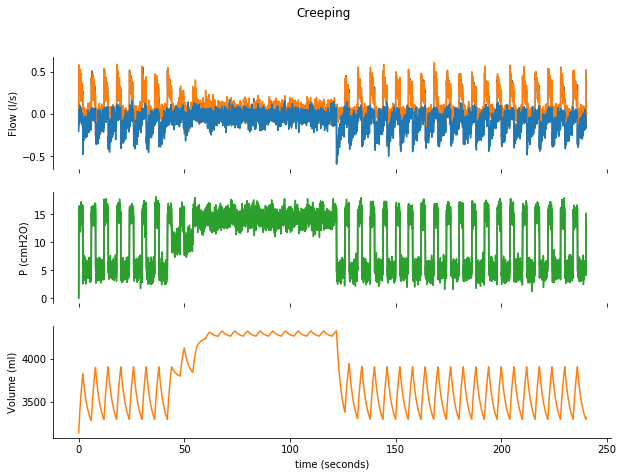

This sim has 4801 observations


In [4]:
scenarios = tt.scenarios(tt.badnesses)
# A full list of scenarios:
# pprint(scenarios.keys())
scenario = scenarios['Creeping']
sim = tt.run_and_output(scenario)
print(f"This sim has {len(sim)} observations")

Targeting αN=0.05, αA=0.1, αR=0.8, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


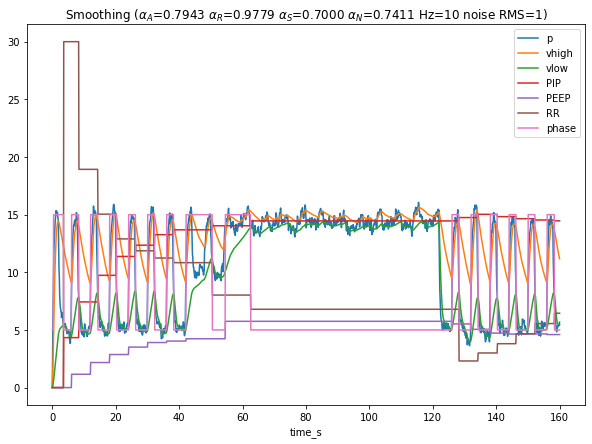

b


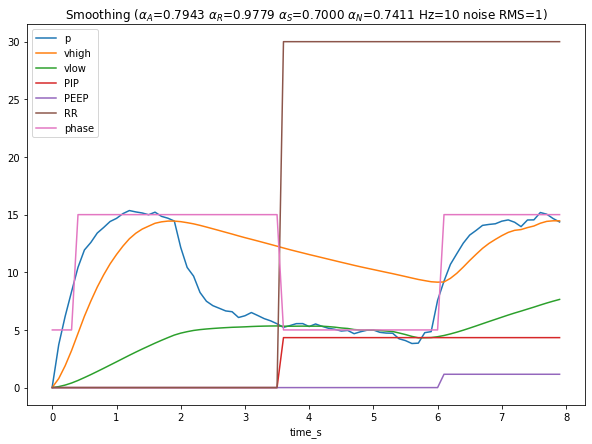

Targeting αN=0.05, αA=0.1, αR=0.9, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


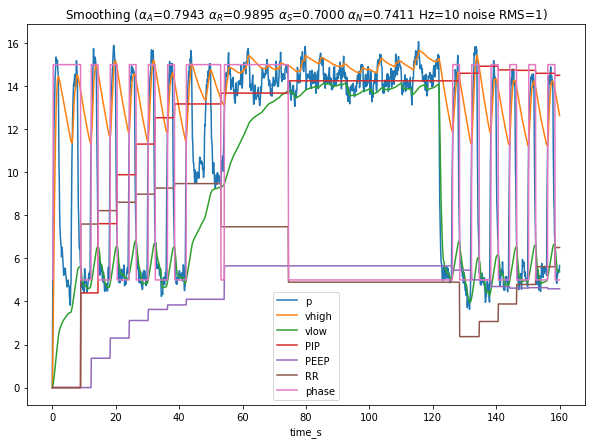

b


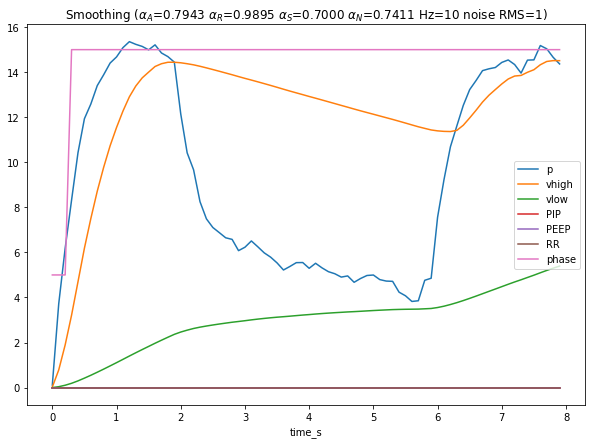

Targeting αN=0.05, αA=0.1, αR=0.97, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


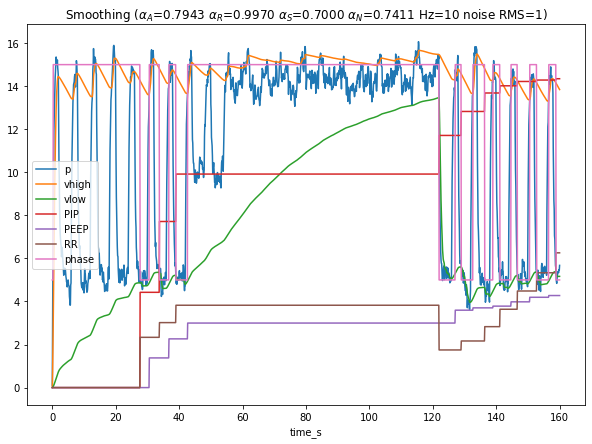

b


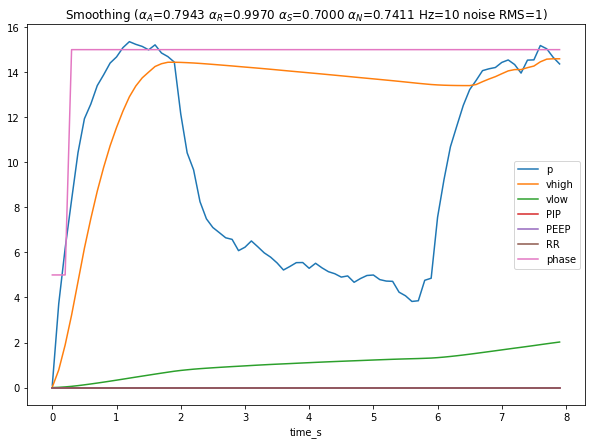

Targeting αN=0.05, αA=0.2, αR=0.8, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


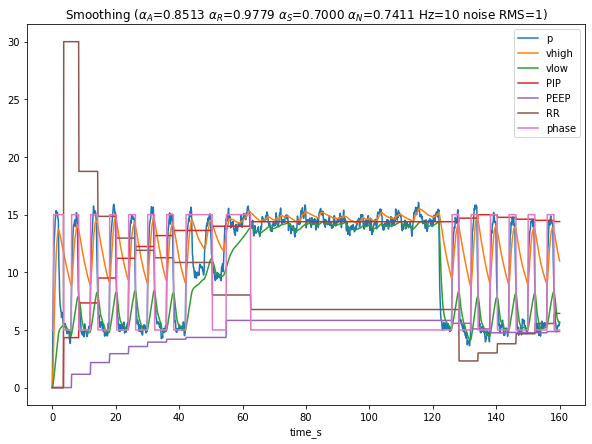

b


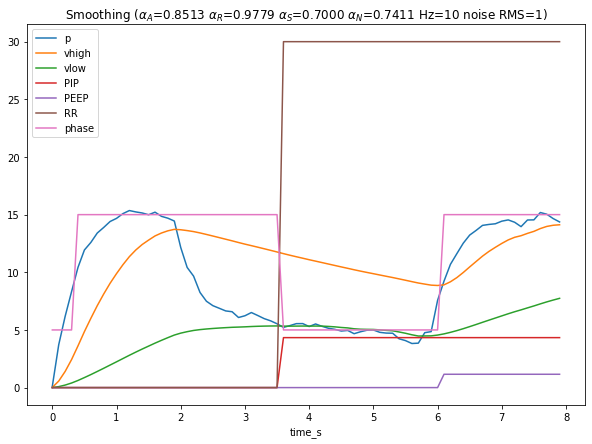

Targeting αN=0.05, αA=0.2, αR=0.9, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


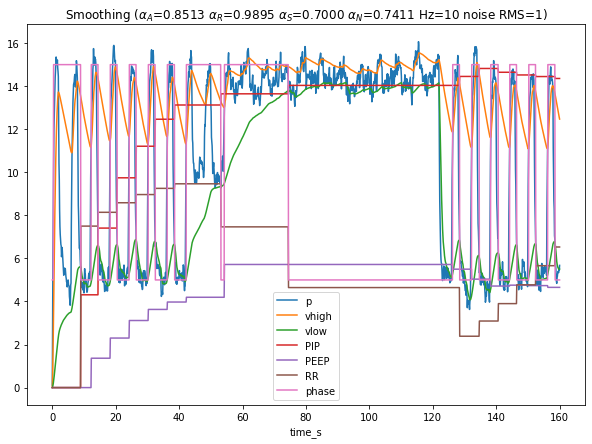

b


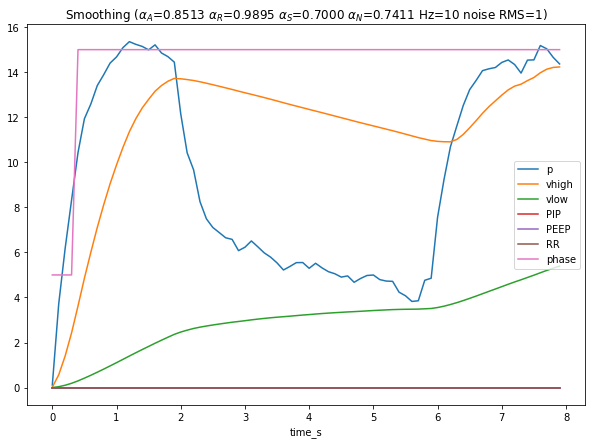

Targeting αN=0.05, αA=0.2, αR=0.97, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


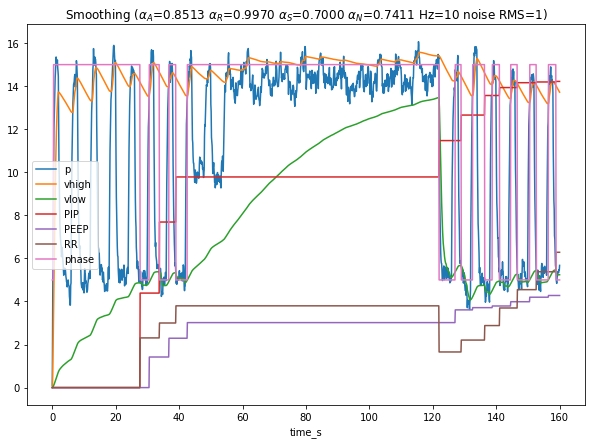

b


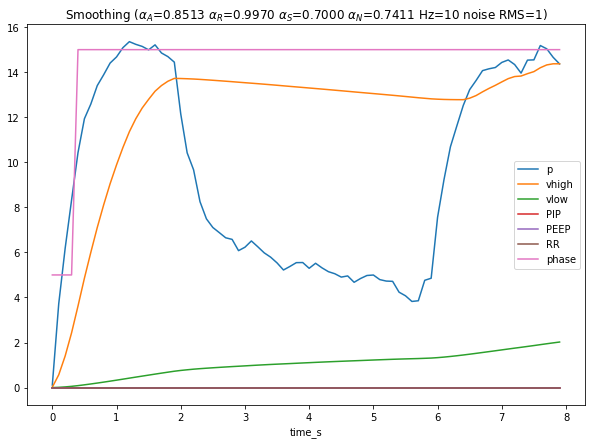

Targeting αN=0.05, αA=0.4, αR=0.8, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


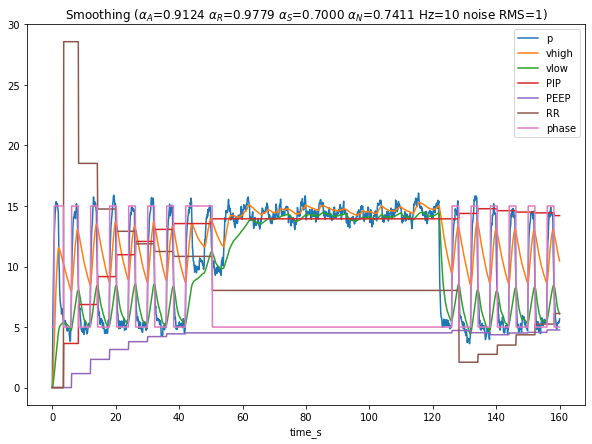

b


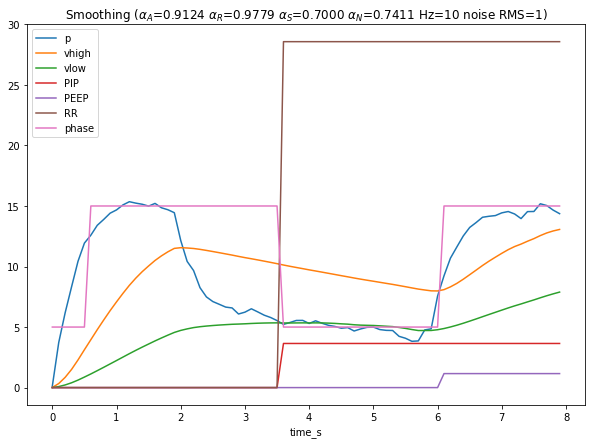

Targeting αN=0.05, αA=0.4, αR=0.9, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


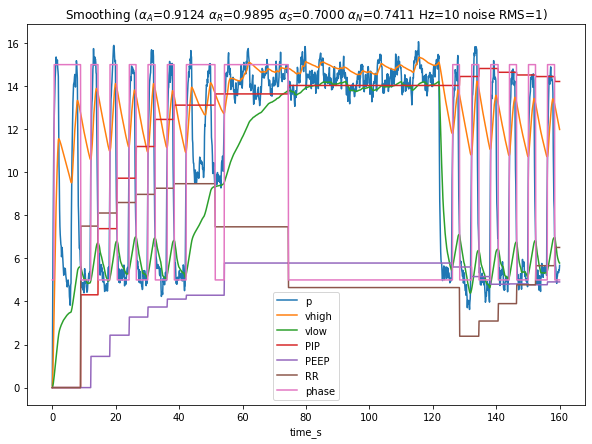

b


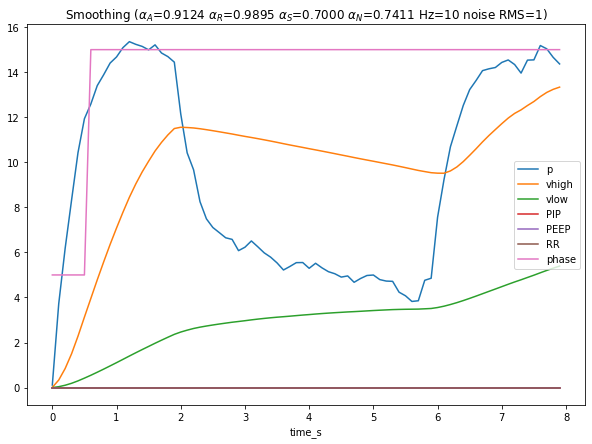

Targeting αN=0.05, αA=0.4, αR=0.97, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


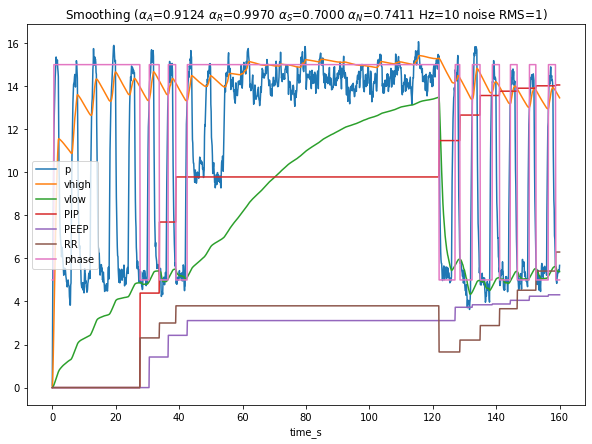

b


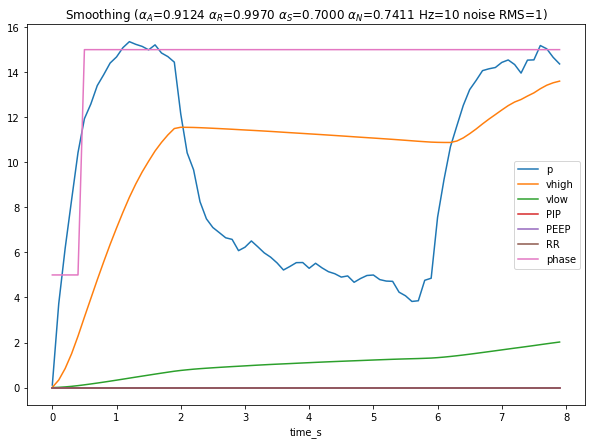

Targeting αN=0.1, αA=0.1, αR=0.8, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


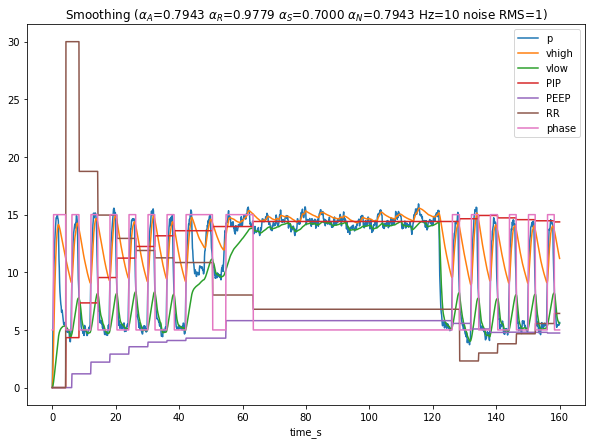

b


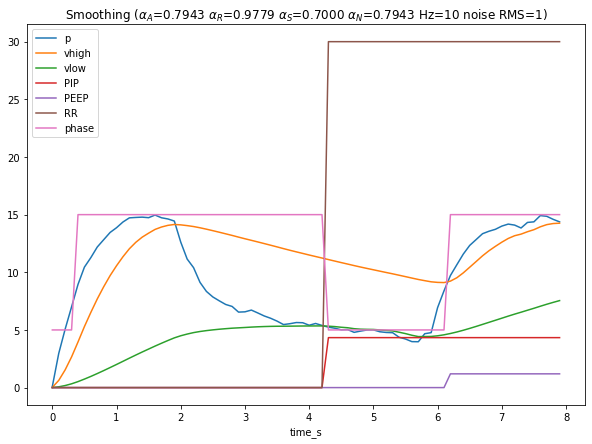

Targeting αN=0.1, αA=0.1, αR=0.9, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


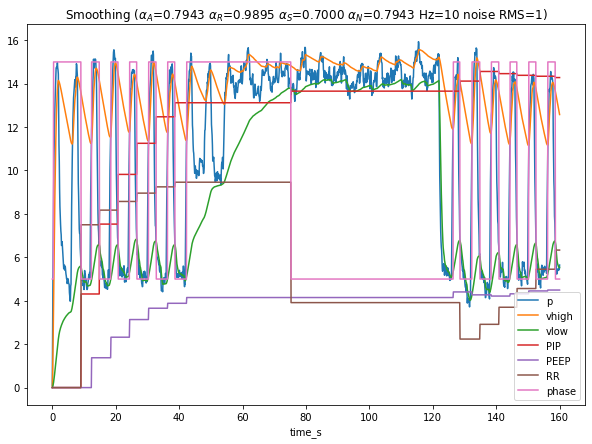

b


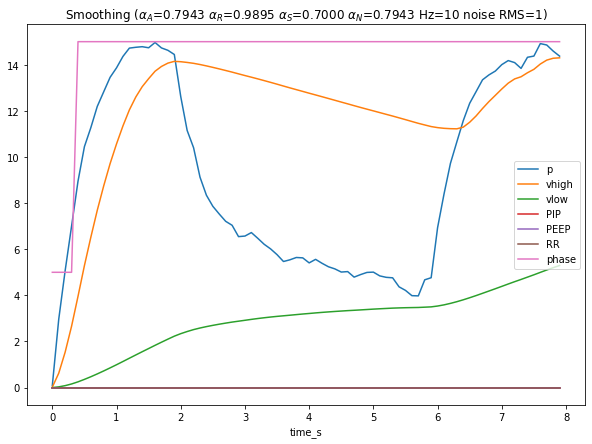

Targeting αN=0.1, αA=0.1, αR=0.97, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


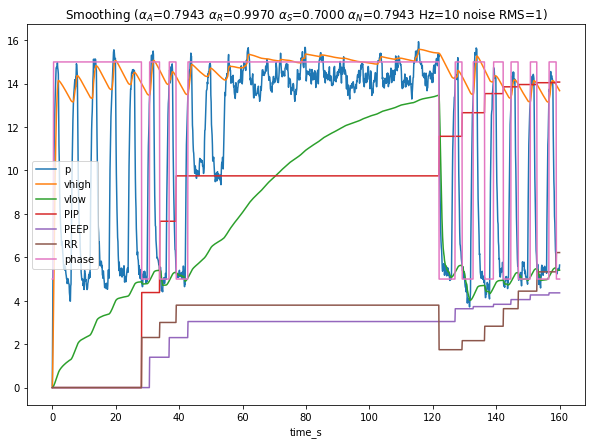

b


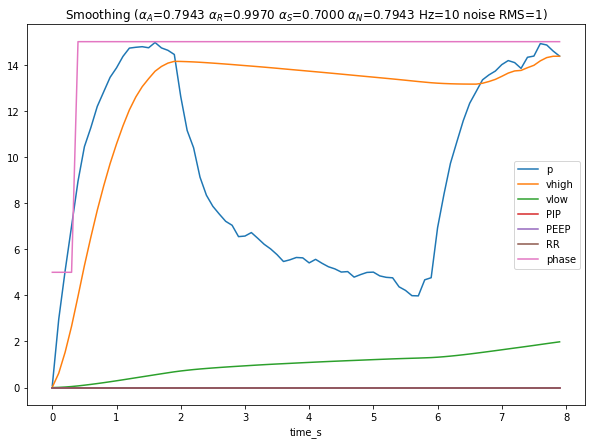

Targeting αN=0.1, αA=0.2, αR=0.8, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


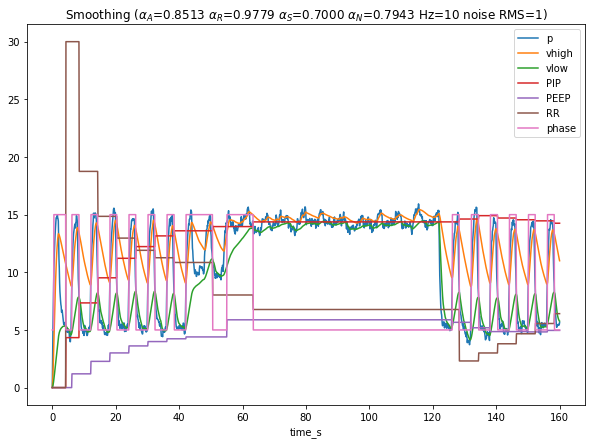

b


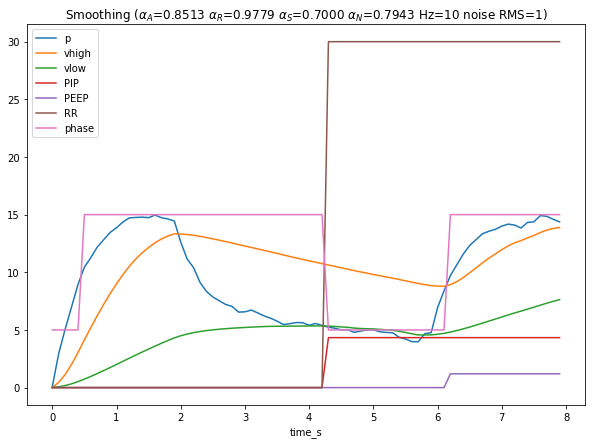

Targeting αN=0.1, αA=0.2, αR=0.9, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


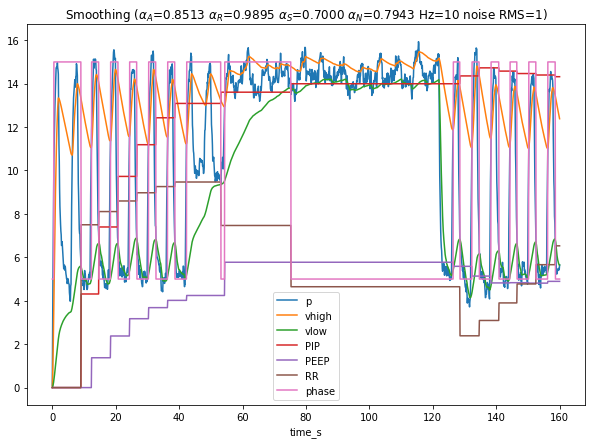

b


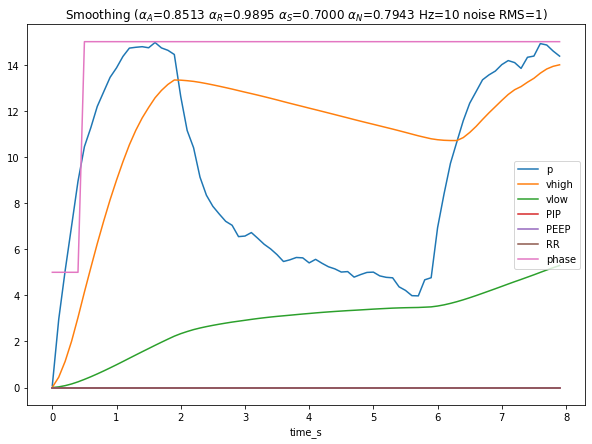

Targeting αN=0.1, αA=0.2, αR=0.97, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


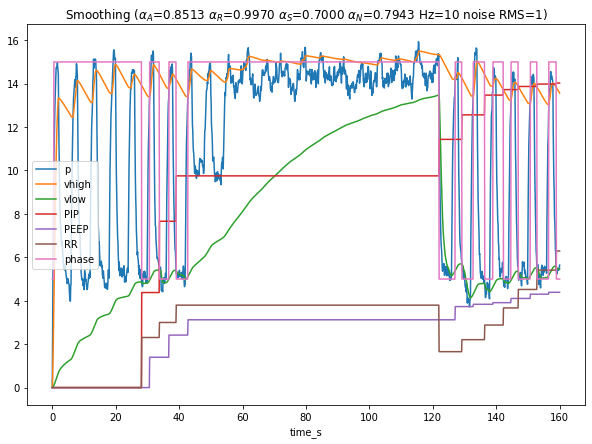

b


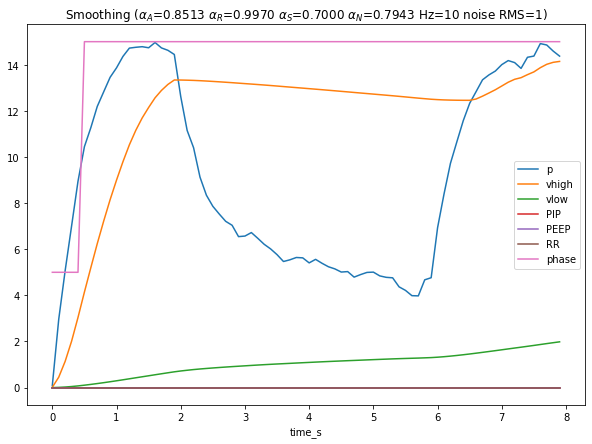

Targeting αN=0.1, αA=0.4, αR=0.8, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


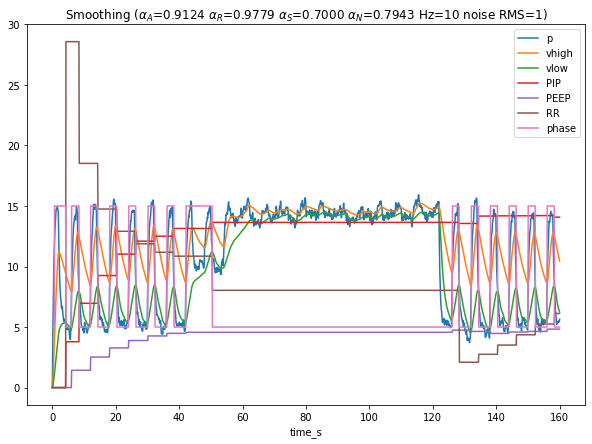

b


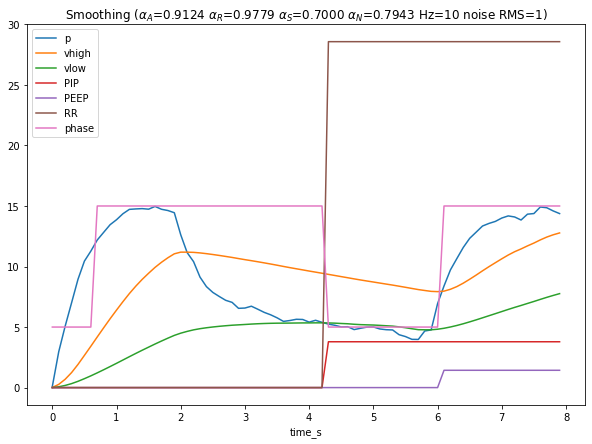

Targeting αN=0.1, αA=0.4, αR=0.9, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


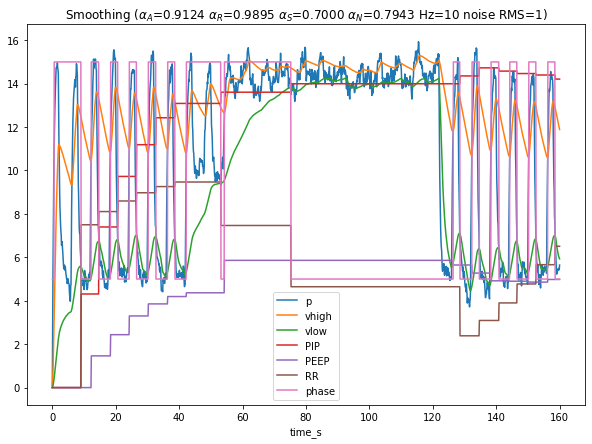

b


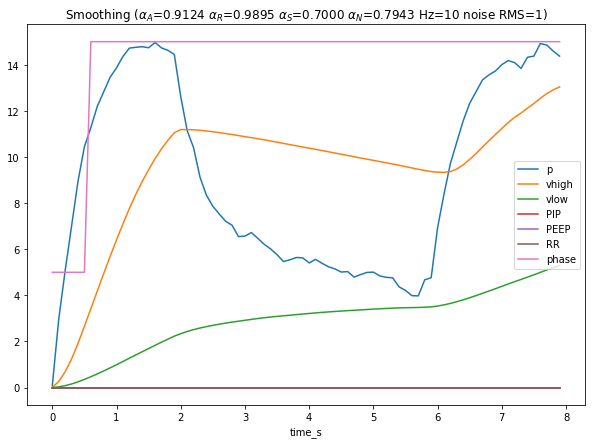

Targeting αN=0.1, αA=0.4, αR=0.97, αS=0.7,  at 10Hz - processed 1601 out of 3201 rows
a


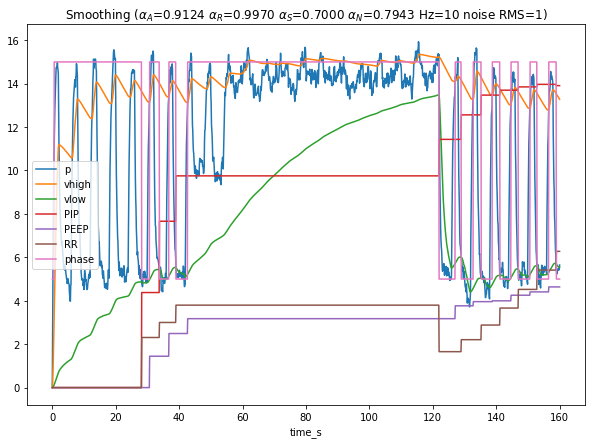

b


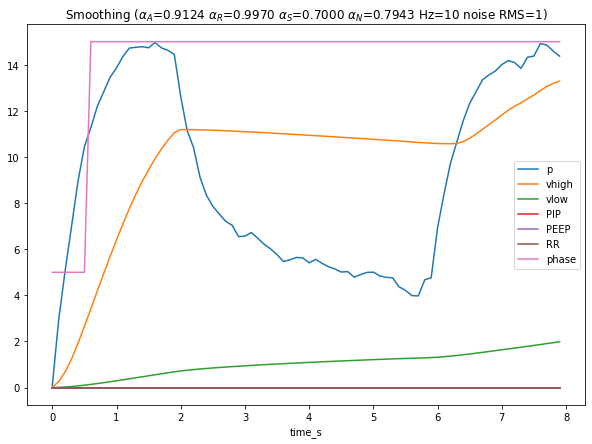

done!


In [5]:
# importlib.reload(signal)
vs = signal.VentilatorStatus()
config = signal.VentilatorConfig()
alpha = "\N{greek small letter alpha}"
records_to_process = round(len(sim) / 1.5)
config.alphaS=0.7
for noise_alpha in [0.05, 0.1]: # 0.01, 0.02]: #, 0.05, 0.1]:
    for loop_frequency in [10]: #, 100]: #Hz
        for attack_alpha in [0.1, 0.2, 0.4]: #, 0.5, 0.66]:
            for release_alpha in [0.8, 0.9, 0.97]:
                config.alphaA = signal.retune_alpha(attack_alpha, loop_frequency)
                config.alphaR = signal.retune_alpha(release_alpha, loop_frequency) # was 0.997 @ 10 hz
                config.sample_frequency = loop_frequency 
                config.alphaN = signal.retune_alpha(noise_alpha, loop_frequency) # was 0.997 @ 10 hz
                results = signal.process_trace(sim.head(records_to_process), config, pressure_column='pressure_1')
                print (f"Targeting {alpha}N={noise_alpha}, {alpha}A={attack_alpha}, {alpha}R={release_alpha}, {alpha}S={config.alphaS}, "
                       f" at {loop_frequency}Hz - processed {len(results)} out of {records_to_process} rows")
                print('a')
                processed_plots(results)
                print('b')
                # first 8 seconds
                processed_plots(results.head(8 * loop_frequency))
print('done!')

In [ ]:
type(round(200.0/10))

In [ ]:
importlib.reload(signal)

for a in [0.8, 0.9, 0.95, 0.96, 0.97, 0.997]:
    for t in [10, 100]:
        print(f"retuning {a} from {t}Hz to 1Hz is {signal.retune_alpha(alpha=a, starting_frequency=t, new_frequency=1)}")
xscenarios = [
    [0.2,1],
    [0.9,10],
    [0.96,10],
    [0.9,10],
    [0.9, 100],
    [0.9895192582062144, 100],
    [signal.retune_alpha(alpha = 0.9, starting_frequency=10, new_frequency=1), 1],
]
for s in xscenarios:
    print(f'{s[0]}**{s[1]} ={s[0]**s[1]}')

In [ ]:
sim.head()